- Implementare un prototipo minimale: un semplice sistema ODE e la sua versione τ-leap per capire il meccanismo.
- Fissare 2 estensioni concrete che siano fattibili in poche ore (es. aggiungere rumore esterno del tipo “parameter jitter” + confronto).

In [3]:
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import numpy as np


### Prototipo ODE + τ-leap 
Obiettivo: capire come si passa da un modello deterministico a uno stocastico.



#### 1) Scegli un sistema semplice e implementa l'ODE

Forma lineare (più semplice):

Considera due specie A e B. Ognuna viene prodotta e degradata, e la produzione è inibita dall’altra
    $$
        \frac{dA}{dt} = k_{\text{prod}} - k_{\text{reg}}B -\gamma A
    $$
    $$
        \frac{dB}{dt} = k_{\text{prod}} - k_{\text{reg}}A -\gamma B
    $$


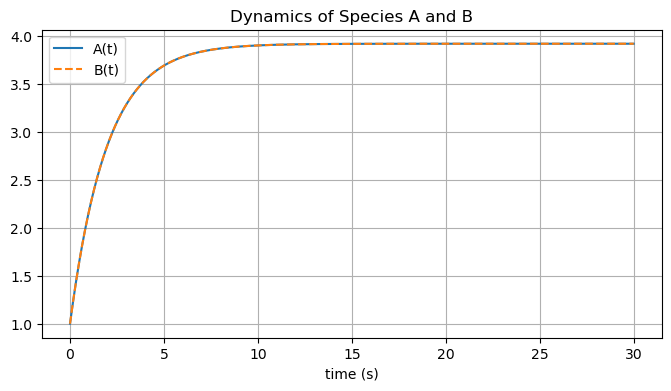

In [ ]:


def system_linear_eq(t, species_conc, k_prod, k_reg, gamma):
    A, B = species_conc
    dA_dt = k_prod - k_reg * B - gamma * A
    dB_dt = k_prod - k_reg * A - gamma * B
    return [dA_dt, dB_dt]

#ODE parameters
k_prod = 2
k_reg = 0.5
gamma = 0.01

A_0, B_0 = 1.0, 1.0 #initial conditions


start_time, end_time = 0, 30
step_size = 0.01

sol = solve_ivp(system_linear_eq, [start_time, end_time], [A_0, B_0], args=[k_prod, k_reg, gamma], max_step=step_size) 

# Extract the results
t = sol.t
A_sol = sol.y[0]
B_sol = sol.y[1]

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(t, A_sol, label='A(t)', linewidth = 1.5)
plt.plot(t, B_sol, label='B(t)', linewidth = 1.5)
plt.xlabel('time (s)')
plt.title('Dynamics of Species A and B')
plt.legend()
plt.grid()
#plt.yscale('log')
plt.show()

Questa versione è “troppo lineare” e non dà bistabilità forte, ma è un buon punto di partenza per vedere la dinamica.

Nel toggle switch reale, ogni gene non si spegne gradualmente ma ha una risposta soglia: sotto un certo livello del repressore, produce tanto; sopra, quasi niente.

$$
    \frac{dA}{dt} = \frac{\alpha}{1+(B/K)^n} -\gamma A 
$$
$$
    \frac{dB}{dt} = \frac{\alpha}{1+(A/K)^n} -\gamma B
$$

Qui la produzione è repressa secondo una funzione di Hill: $K$ è la costante di mezza inibizione, $n$ la cooperatività.

La soglia si modella con una funzione di Hill:

- n=1 → curva monotona dolce (tipo lineare) → niente bistabilità.
- n >> 1 → curva a transizione rapida → possibile bistabilità.

https://en.wikipedia.org/wiki/Hill_equation_(biochemistry)
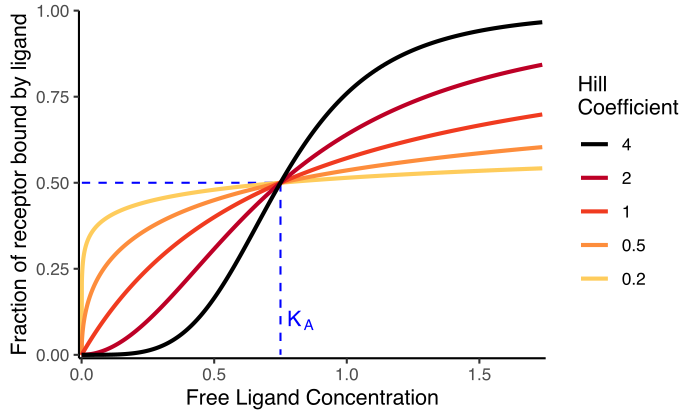
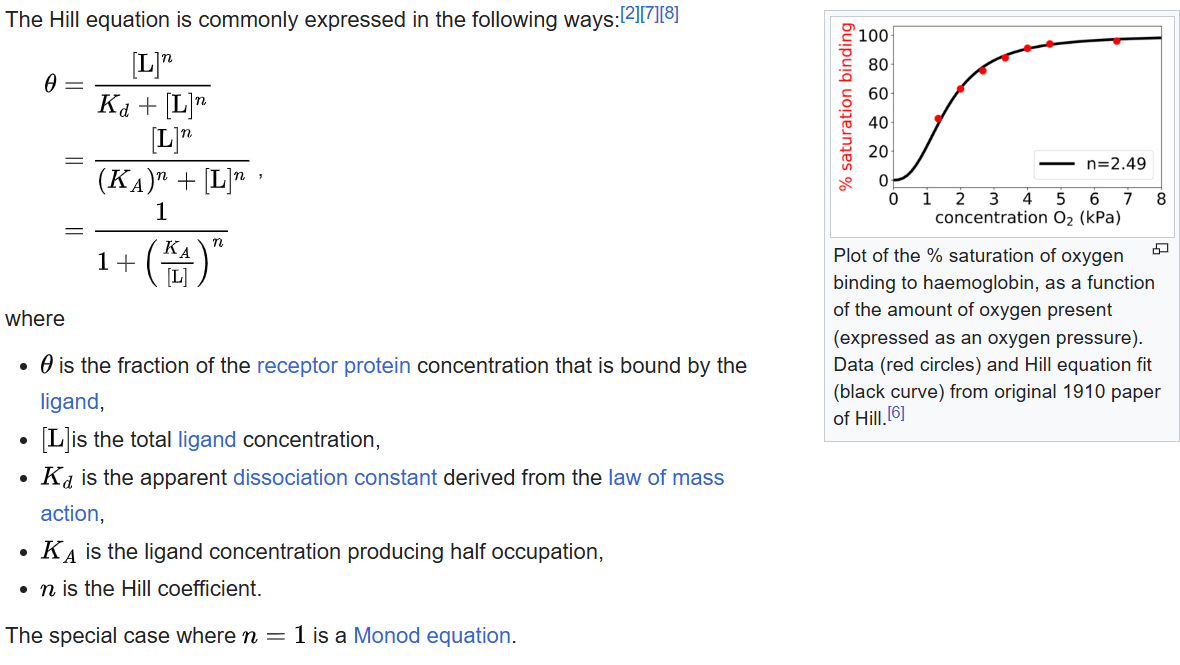

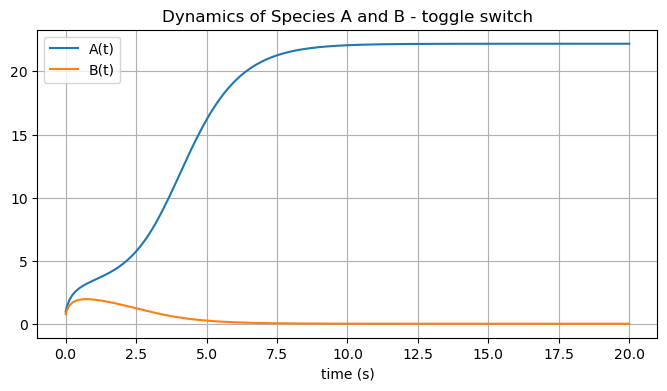

In [69]:
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import numpy as np


def non_linear_system(t, species_conc, alpha, K_param, n_param, gamma):
    A, B = species_conc
    dA_dt = alpha/(1+(B/K_param)**n_param) - gamma * A
    dB_dt = alpha/(1+(A/K_param)**n_param) - gamma * B
    return [dA_dt, dB_dt]

#ODE parameters
alpha = 20
K_param = 1
n_param = 2
gamma = 0.9

A_0, B_0 = 1, 0.8 #initial conditions 


start_time, end_time = 0, 20
step_size = 0.1

sol = solve_ivp(non_linear_system, [start_time, end_time], [A_0, B_0], args=[alpha, K_param, n_param, gamma], max_step=step_size) 

# Extract the results
t = sol.t
A_sol = sol.y[0]
B_sol = sol.y[1]

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(t, A_sol, label='A(t)', linewidth = 1.5)
plt.plot(t, B_sol, label='B(t)', linewidth = 1.5)
plt.xlabel('time (s)')
plt.title('Dynamics of Species A and B - toggle switch')
plt.legend()
plt.grid()
#plt.yscale('log')
plt.show()

Nota come una piccola quantità iniziale in più di una specie rispetto all'altra la porti a dominare alla fine

### 2) Versione stocastica, $\tau$-leap 

https://en.wikipedia.org/wiki/Tau-leaping

In [5]:
#ODE parameters
alpha = 20
K_param = 1
n_param = 2
gamma = 0.9

A_0, B_0 = 1, 0.8 #initial conditions 


start_time, end_time = 0, 20
step_size = 0.001

In [13]:
def run_tau_leap(alpha, K_param, n_param, gamma, A_0, B_0, start_time, end_time, step_size, show=True):

    A,B = A_0, B_0 # initial conditions

    A_values, B_values = [A], [B]  # Lists to store the results
    t_values = [start_time]  # List to store time values
    for t in np.arange(start_time+step_size, end_time, step_size):
        # Calculate propensity functions
        a1 = alpha / (1 + (B / K_param) ** n_param)
        a2 = alpha / (1 + (A / K_param) ** n_param)
        a3 = gamma * A
        a4 = gamma * B

        delta_N1 = np.random.poisson(a1 * step_size)
        delta_N2 = np.random.poisson(a2 * step_size)
        delta_N3 = np.random.poisson(a3 * step_size)
        delta_N4 = np.random.poisson(a4 * step_size)

        A = max(0, A + delta_N1 - delta_N3)
        B = max(0, B + delta_N2 - delta_N4)

        # Store the results
        t_values.append(t)
        A_values.append(A)
        B_values.append(B)

    t_values = np.array(t_values)
    A_values = np.array(A_values)
    B_values = np.array(B_values)   

    if show:
        # Plot the results
        plt.figure(figsize=(8, 4))
        plt.plot(t_values, A_values, label='A(t)', linewidth = 1.5)
        plt.plot(t_values, B_values, label='B(t)', linewidth = 1.5)
        plt.xlabel('time (s)')
        plt.title('Dynamics of Species A and B - tau leap')
        plt.legend()
        plt.grid()
        #plt.yscale('log')
        plt.show()

    return t_values, A_values, B_values



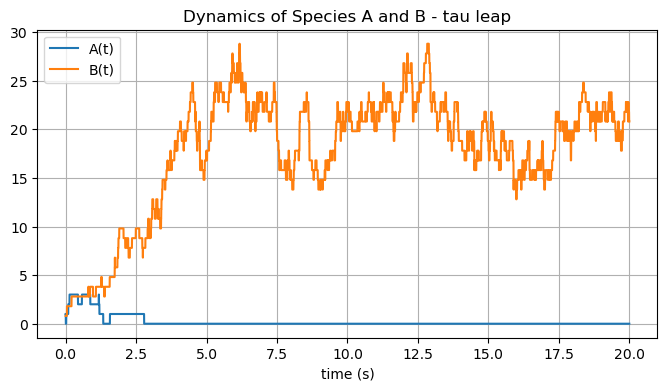

In [76]:
run_tau_leap(alpha, K_param, n_param, gamma, A_0, B_0, start_time, end_time, step_size)

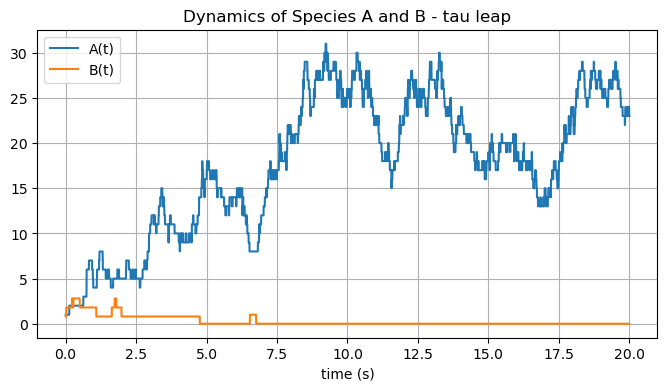

In [78]:
run_tau_leap(alpha, K_param, n_param, gamma, A_0, B_0, start_time, end_time, step_size)

the stochasticity lead to different behaviours. In the deterministic case we would not be able to see minority species to end up dominating


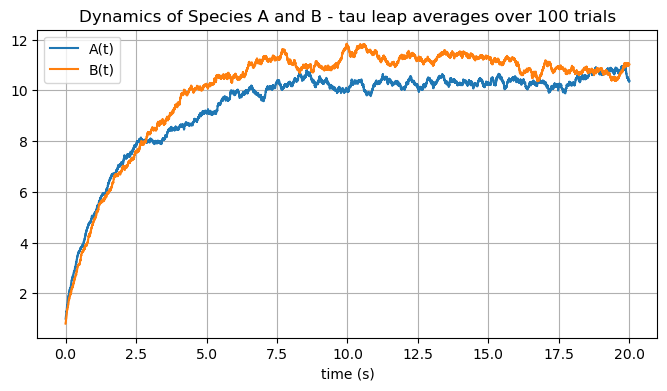

In [17]:
## running multiple simulations and taking the average
n_sim = 100  # Number of simulations
A_avg = np.zeros(int((end_time - start_time) / step_size))
B_avg = np.zeros(int((end_time - start_time) / step_size))

for _ in range(n_sim):
    t_values, A_values, B_values = run_tau_leap(alpha, K_param, n_param, gamma, A_0, B_0, start_time, end_time, step_size, show=False)
    A_avg += A_values
    B_avg += B_values
A_avg /= n_sim
B_avg /= n_sim

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(t_values, A_avg, label='A(t)', linewidth = 1.5)
plt.plot(t_values, B_avg, label='B(t)', linewidth = 1.5)
plt.xlabel('time (s)')
plt.title(f'Dynamics of Species A and B - tau leap averages over {n_sim} trials')
plt.legend()
plt.grid()
#plt.yscale('log')
plt.show()